# Representation Learning


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tarfile
import glob
from datetime import datetime
import math
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, silhouette_score, adjusted_rand_score, roc_curve, precision_recall_curve
from sklearn.metrics import normalized_mutual_info_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix
import random

### Q3.1 Pretraining and Linear Probes (4 pts)

### Used transformer architecture similar to Q2.2 implementation

In [2]:
from torch.utils.data import DataLoader, Dataset
class PatientDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
batch_size = 64

# Training Data
df = pd.read_parquet('final-data/final-set-a.parquet')
X_a = df.fillna(0)
X_a = X_a.groupby("RecordID").tail(49).reset_index(drop=True)
X_a = X_a.sort_values(by="RecordID", ascending=True)
X_a["Time"] = scaler.fit_transform(X_a[["Time"]])
X_a = X_a.drop(columns=["RecordID"]).drop(columns=["MechVent"])
X_a = X_a[sorted(X_a.columns)]
X_a = X_a.to_numpy()
X_a = X_a.reshape(4000,49,40)

train_dataset = PatientDataset(X_a, X_a)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Validation data
df = pd.read_parquet('final-data/final-set-b.parquet')
X_b = df.fillna(0)
X_b = X_b.groupby("RecordID").tail(49).reset_index(drop=True)
X_b = X_b.sort_values(by="RecordID", ascending=True)
X_b["Time"] = scaler.fit_transform(X_b[["Time"]])
X_b = X_b.drop(columns=["RecordID"]).drop(columns=["ICUType"]).drop(columns=["MechVent"])
X_b = X_b[sorted(X_b.columns)]
X_b = X_b.to_numpy()
X_b = X_b.reshape(4000,49,40)

val_dataset = PatientDataset(X_b, X_b)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Test data
df = pd.read_parquet('final-data/final-set-c.parquet')
X_c = df.fillna(0)
X_c = X_c.groupby("RecordID").tail(49).reset_index(drop=True)
X_c = X_c.sort_values(by="RecordID", ascending=True)
X_c["Time"] = scaler.fit_transform(X_c[["Time"]])
X_c = X_c.drop(columns=["RecordID"]).drop(columns=["ICUType"]).drop(columns=["MechVent"])
X_c = X_c[sorted(X_c.columns)]
X_c = X_c.to_numpy()
X_c = X_c.reshape(4000,49,40)

test_dataset = PatientDataset(X_c, X_c)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [4]:
# Transformer from Q2.3a without FC layer for classification

class TransformerEncoder(nn.Module):
    def __init__(self, input_size=40, latent_dim=16, seq_length=49, num_heads=4, num_layers=3, dim_feedforward=512, dropout=0.1):
        super(TransformerEncoder, self).__init__()

        self.embedding = nn.Linear(input_size, latent_dim)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=latent_dim,  # Dimensionality of the embeddings
            nhead=num_heads, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout, 
            batch_first=True
        )
        
        # Stacking multiple transformer layers
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        return x

In [5]:
# Decoder to decode latent space data to original space

class TransformerDecoder(nn.Module):
    def __init__(self, output_dim=40, latent_dim=16, num_heads=4, dim_feedforward=128, num_layers=3):
        super(TransformerDecoder, self).__init__()

        self.input_layer = nn.Linear(latent_dim, latent_dim)
        self.output_layer = nn.Linear(latent_dim, output_dim)
        
        # Use latent_dim for the decoder layers
        decoder_layers = nn.TransformerDecoderLayer(d_model=latent_dim, nhead=num_heads, dim_feedforward=dim_feedforward, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layers, num_layers=num_layers)
        
    def forward(self, latent, memory=None):
        x_reconstructed = self.input_layer(latent)  # Project back to latent_dim
        x_reconstructed = self.decoder(x_reconstructed, memory)  # Transformer decoder
        x_reconstructed = self.output_layer(x_reconstructed)  # Project back to original input_dim (output_dim)
        return x_reconstructed

In [6]:
class TransformerAutoencoder(nn.Module):
    def __init__(self, input_dim=40, seq_length=49, latent_dim=16, num_heads=4, dim_feedforward=128, num_layers=3):
        super(TransformerAutoencoder, self).__init__()
        self.encoder = TransformerEncoder(input_dim, latent_dim=latent_dim, seq_length=seq_length, num_heads=num_heads, num_layers=num_layers, dim_feedforward=dim_feedforward)
        self.decoder = TransformerDecoder(output_dim=input_dim, latent_dim=latent_dim, num_heads=num_heads, num_layers=num_layers, dim_feedforward=dim_feedforward)
    
    def forward(self, x):
        latent = self.encoder(x)  # Get the latent representation from the encoder
        x_reconstructed = self.decoder(latent, latent)  # Pass latent to the decoder
        return x_reconstructed, latent

100%|██████████| 63/63 [00:11<00:00,  5.42it/s]


Epoch 1/25, Train Loss: 0.671032, Val Loss: 0.847407


100%|██████████| 63/63 [00:12<00:00,  5.10it/s]


Epoch 2/25, Train Loss: 0.536632, Val Loss: 0.765010


100%|██████████| 63/63 [00:12<00:00,  5.00it/s]


Epoch 3/25, Train Loss: 0.465428, Val Loss: 0.703947


100%|██████████| 63/63 [00:15<00:00,  4.04it/s]


Epoch 4/25, Train Loss: 0.414865, Val Loss: 0.659701


100%|██████████| 63/63 [00:16<00:00,  3.87it/s]


Epoch 5/25, Train Loss: 0.378865, Val Loss: 0.632177


100%|██████████| 63/63 [00:11<00:00,  5.55it/s]


Epoch 6/25, Train Loss: 0.353785, Val Loss: 0.609513


100%|██████████| 63/63 [00:10<00:00,  5.98it/s]


Epoch 7/25, Train Loss: 0.334750, Val Loss: 0.593088


100%|██████████| 63/63 [00:10<00:00,  5.83it/s]


Epoch 8/25, Train Loss: 0.319765, Val Loss: 0.578147


100%|██████████| 63/63 [00:10<00:00,  5.97it/s]


Epoch 9/25, Train Loss: 0.304046, Val Loss: 0.859547


100%|██████████| 63/63 [00:10<00:00,  5.94it/s]


Epoch 10/25, Train Loss: 0.292353, Val Loss: 0.556934


100%|██████████| 63/63 [00:10<00:00,  5.88it/s]


Epoch 11/25, Train Loss: 0.281990, Val Loss: 0.550351


100%|██████████| 63/63 [00:10<00:00,  5.93it/s]


Epoch 12/25, Train Loss: 0.276400, Val Loss: 0.544361


100%|██████████| 63/63 [00:10<00:00,  5.87it/s]


Epoch 13/25, Train Loss: 0.268790, Val Loss: 0.539535


100%|██████████| 63/63 [00:10<00:00,  5.78it/s]


Epoch 14/25, Train Loss: 0.266128, Val Loss: 0.535801


100%|██████████| 63/63 [00:10<00:00,  5.93it/s]


Epoch 15/25, Train Loss: 0.258960, Val Loss: 0.532336


100%|██████████| 63/63 [00:10<00:00,  6.08it/s]


Epoch 16/25, Train Loss: 0.255309, Val Loss: 0.530782


100%|██████████| 63/63 [00:10<00:00,  6.09it/s]


Epoch 17/25, Train Loss: 0.252028, Val Loss: 0.527946


100%|██████████| 63/63 [00:10<00:00,  6.15it/s]


Epoch 18/25, Train Loss: 0.250037, Val Loss: 0.525918


100%|██████████| 63/63 [00:10<00:00,  6.12it/s]


Epoch 19/25, Train Loss: 0.247514, Val Loss: 0.525441


100%|██████████| 63/63 [00:10<00:00,  6.11it/s]


Epoch 20/25, Train Loss: 0.245570, Val Loss: 0.523384


100%|██████████| 63/63 [00:10<00:00,  6.12it/s]


Epoch 21/25, Train Loss: 0.243753, Val Loss: 0.521164


100%|██████████| 63/63 [00:10<00:00,  6.12it/s]


Epoch 22/25, Train Loss: 0.242252, Val Loss: 0.520177


100%|██████████| 63/63 [00:10<00:00,  6.08it/s]


Epoch 23/25, Train Loss: 0.241233, Val Loss: 0.519538


100%|██████████| 63/63 [00:10<00:00,  6.08it/s]


Epoch 24/25, Train Loss: 0.239223, Val Loss: 0.518031


100%|██████████| 63/63 [00:10<00:00,  6.09it/s]


Epoch 25/25, Train Loss: 0.238930, Val Loss: 0.516749


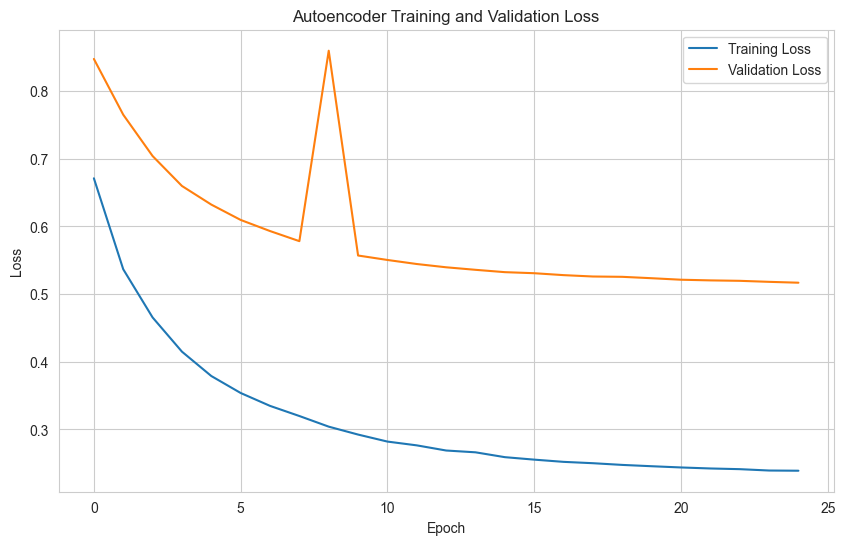

<All keys matched successfully>

In [7]:
# Initialize model and optimization
hidden_dim = 128
autoencoder = TransformerAutoencoder()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = autoencoder.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop
num_epochs = 25
train_losses = []
val_losses = []

# Early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0

if not os.path.exists("embedding_autoencoder_transformer"):
        os.makedirs("embedding_autoencoder_transformer")


for epoch in range(num_epochs):
    # Training
    autoencoder.train()
    epoch_loss = 0
    
    for batch_idx, (data, _) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        
        # Forward pass
        reconstructed, _ = autoencoder(data)
        loss = criterion(reconstructed, data)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    autoencoder.eval()
    val_loss = 0
    
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)
            reconstructed, _ = autoencoder(data)
            loss = criterion(reconstructed, data)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    # Print progress
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save best model
        torch.save(autoencoder.state_dict(), 'embedding_autoencoder_transformer/best_autoencoder_transformer.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping after {epoch+1} epochs')
            break

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder Training and Validation Loss')
plt.legend()
plt.savefig('embedding_autoencoder_transformer/autoencoder_loss_transformer.png')
plt.show()

# Load the best model
autoencoder.load_state_dict(torch.load('embedding_autoencoder_transformer/best_autoencoder_transformer.pth'))

### Linear Probe

In [8]:
# Takes input data as tensor and returns embeddings (e.g., 4000x49x40 => 4000x16)
def create_embeddings(input_data, model, device='cuda'):
    model.eval()
    input_data = input_data.to(device)
    with torch.no_grad():
        latent_embeddings = model.encoder(input_data)
    embeddings = latent_embeddings.mean(dim=1)  #mean of all time stamps
    #embeddings = latent_embeddings[:, -1, :]   #last time stamp at 48h, different approach
    
    return embeddings

In [9]:
# Take embeddings and load labels
X_a_tensor = torch.tensor(X_a, dtype=torch.float32)
X_train = create_embeddings(X_a_tensor, autoencoder, 'cpu')
print(X_train.shape)
X_train = X_train.cpu()
y_df = pd.read_parquet('processed-data/processed-outcomes-a.parquet')
y_train = y_df["In-hospital_death"].to_numpy().flatten()

X_b_tensor = torch.tensor(X_b, dtype=torch.float32)
X_val = create_embeddings(X_b_tensor, autoencoder, 'cpu')
X_val = X_val.cpu()
y_df = pd.read_parquet('processed-data/processed-outcomes-b.parquet')
y_val = y_df["In-hospital_death"].to_numpy().flatten()

# Loading test set C
X_c_tensor = torch.tensor(X_c, dtype=torch.float32)
X_test = create_embeddings(X_c_tensor, autoencoder, 'cpu')
X_test = X_test.cpu()
y_df = pd.read_parquet('processed-data/processed-outcomes-c.parquet')
y_test = y_df["In-hospital_death"].to_numpy().flatten()

torch.Size([4000, 16])


C=0.001, Validation AuROC: 0.7724, Validation AuPRC: 0.3884
C=0.01, Validation AuROC: 0.7869, Validation AuPRC: 0.4001
C=0.1, Validation AuROC: 0.7923, Validation AuPRC: 0.4034
C=1, Validation AuROC: 0.7930, Validation AuPRC: 0.4041
C=10, Validation AuROC: 0.7929, Validation AuPRC: 0.4038
C=100, Validation AuROC: 0.7929, Validation AuPRC: 0.4038
Best validation AuROC: 0.7930
Test AuROC: 0.7974
Test AuPRC: 0.4282


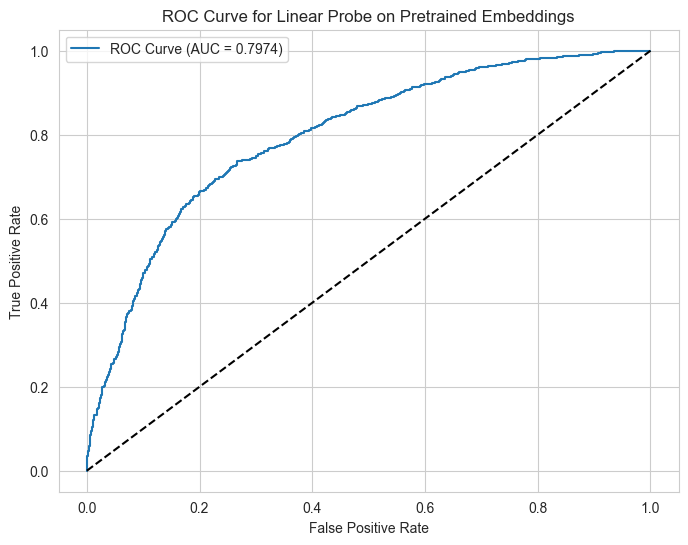

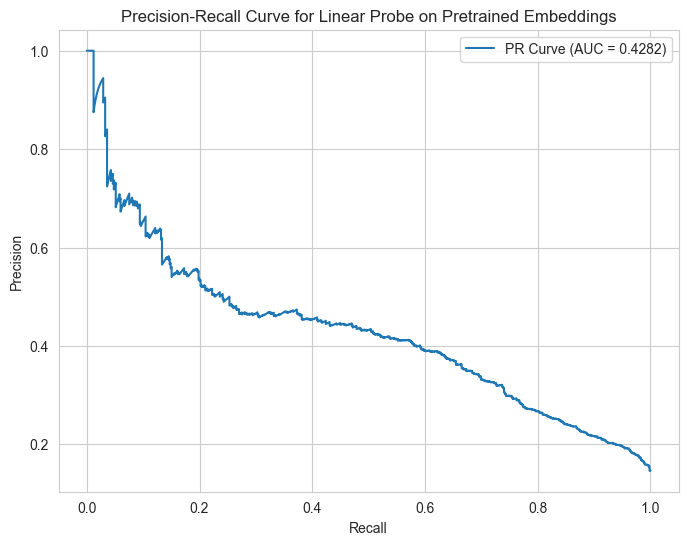

In [10]:
# Logistic Regression, try different regularization strengths
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
best_val_auc = 0
best_model = None

for C in C_values:
    model = LogisticRegression(C=C, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    
    val_probs = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_probs)
    val_auprc = average_precision_score(y_val, val_probs)
    
    print(f"C={C}, Validation AuROC: {val_auc:.4f}, Validation AuPRC: {val_auprc:.4f}")
    
    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_model = model

print(f"Best validation AuROC: {best_val_auc:.4f}")

# Evaluation on test set
# Make predictions
test_probs = best_model.predict_proba(X_test)[:, 1]

test_auc = roc_auc_score(y_test, test_probs)
test_auprc = average_precision_score(y_test, test_probs)

print(f"Test AuROC: {test_auc:.4f}")
print(f"Test AuPRC: {test_auprc:.4f}")


fpr, tpr, _ = roc_curve(y_test, test_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Linear Probe on Pretrained Embeddings')
plt.legend()
plt.savefig('embedding_autoencoder_transformer/roc_curve.png')
plt.show()

precision, recall, _ = precision_recall_curve(y_test, test_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {test_auprc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Linear Probe on Pretrained Embeddings')
plt.legend()
plt.savefig('embedding_autoencoder_transformer/pr_curve.png')
plt.show()

### Q3.2 Simulate label scarcity (4 pts)

### Q3.2 Part i)

We train three different supervised models with the architecture of our pretrained network(transformer), but only use 100, 500, and 1000 patients from the training set and evaluate on the full test set.

In [11]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [12]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_size=16, latent_dim=16, num_heads=4, num_layers=3, dim_feedforward=512, dropout=0.1):
        super(TransformerClassifier, self).__init__()

        self.embedding = nn.Linear(input_size, latent_dim)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=latent_dim,  
            nhead=num_heads, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout, 
            batch_first=True
        )
        
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)
            
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        x = x[:, 0, :]
        x = self.classifier(x)
        return x.squeeze()

In [13]:
def create_subsampled_datasets(X_train, y_train, sample_sizes=[100, 500, 1000]):
    datasets = {}
    
    for size in sample_sizes:
        indices = np.random.choice(len(X_train), size=size, replace=False)
        X_subset = X_train[indices]
        y_subset = y_train[indices]
        datasets[size] = (X_subset, y_subset)
    
    return datasets

In [14]:
def train_model(model, train_loader, criterion, optimizer, device, epochs=50):
    model.train()
    train_losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_epoch_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_epoch_loss)
    
    return train_losses

In [15]:
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_probs = [] 
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            outputs = model(X_batch)
            predicted = (outputs > 0.5).float()
            
            all_probs.extend(outputs.cpu().numpy())  # Store raw probabilities
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    # Calculate standard metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    
    # Calculate AUROC and AUPRC
    auroc = roc_auc_score(all_labels, all_probs)
    auprc = average_precision_score(all_labels, all_probs)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auroc': auroc,
        'auprc': auprc
    }

In [16]:
def run_experiment(X_train, y_train, X_test, y_test, sample_sizes=[100, 500, 1000]):
    path = "embedding_autoencoder_transformer"
    if not os.path.exists(path):
       os.makedirs(path)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    if not isinstance(X_train, torch.Tensor):
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32)
        X_test = torch.tensor(X_test, dtype=torch.float32)
        y_test = torch.tensor(y_test, dtype=torch.float32)
    
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
    
    test_dataset = TensorDataset(X_test, y_test) #evaluate on full test data
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    subsampled_datasets = create_subsampled_datasets(X_train, y_train, sample_sizes)
    
    results = {}
    training_losses = {}
    
    for size, (X_subset, y_subset) in subsampled_datasets.items():
        train_dataset = TensorDataset(X_subset, y_subset)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        
        model = TransformerClassifier(
            input_size=X_train.shape[1],
            latent_dim=16,
            num_heads=4,
            num_layers=3,
            dim_feedforward=512,
            dropout=0.1
        ).to(device)
        
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        losses = train_model(model, train_loader, criterion, optimizer, device, epochs=50)
        training_losses[size] = losses
        
        metrics = evaluate_model(model, test_loader, device)
        results[size] = metrics

        torch.save(model.state_dict(), f"{path}/transformer_classifier_samples_{size}.pt")
    
    plt.figure(figsize=(10, 6))
    for size, losses in training_losses.items():
        plt.plot(losses, label=f'{size} samples')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss vs. Epoch')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{path}/training_losses.png')
    
    return results, training_losses


Summary of Results:

Model trained with 100 samples:
  accuracy: 0.8157
  precision: 0.3296
  recall: 0.2513
  f1: 0.2852
  auroc: 0.6378
  auprc: 0.2528

Model trained with 500 samples:
  accuracy: 0.8197
  precision: 0.3577
  recall: 0.2923
  f1: 0.3217
  auroc: 0.7005
  auprc: 0.3165

Model trained with 1000 samples:
  accuracy: 0.8395
  precision: 0.4164
  recall: 0.2427
  f1: 0.3067
  auroc: 0.7174
  auprc: 0.3306

Model trained with 2000 samples:
  accuracy: 0.8522
  precision: 0.4890
  recall: 0.2274
  f1: 0.3104
  auroc: 0.7670
  auprc: 0.3706


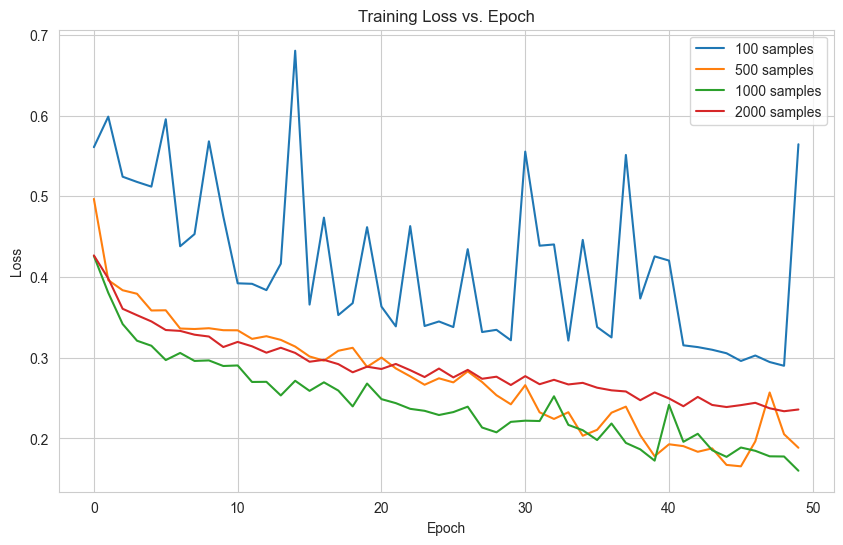

In [17]:
results, losses = run_experiment(X_train, y_train, X_test, y_test, sample_sizes=[100, 500, 1000, 2000])
print("\nSummary of Results:")
for size, metrics in results.items():
    print(f"\nModel trained with {size} samples:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")

### Q3.2 Part ii)

We train three linear probes (as in Q3.1 step 2) using 100-3900 labelled patients and report the full test set C performance (2 pts).

In [19]:
# Assuming we have
# - X_train, y_train: Test data embeddings and labels (from set A)
# - X_test, y_test: Test data embeddings and labels (from set C)
def train_linear_probe_sparse(X_train, y_train, X_test, y_test, n_samples):
    """
    Train a logistic regression model using only n_samples labeled examples
    """
    # Randomly sample n patients, we use stratified sampling to maintain class imbalance
    _, X_sampled, _, y_sampled = train_test_split(
        X_train, y_train, 
        test_size=n_samples/len(y_train),
        stratify=y_train,
        random_state=42
    )
        
    print(f"Training with {len(y_sampled)} samples")
    
    # Train logistic regression
    model = LogisticRegression(C=10.0, max_iter=1000, random_state=42)
    model.fit(X_sampled, y_sampled)
    
    # Evaluate on test set
    test_probs = model.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, test_probs)
    test_auprc = average_precision_score(y_test, test_probs)
    
    return model, test_auc, test_auprc


Training with 100 labeled samples:
Training with 100 samples
Test AuROC: 0.7387
Test AuPRC: 0.3411

Training with 200 labeled samples:
Training with 200 samples
Test AuROC: 0.7741
Test AuPRC: 0.3988

Training with 300 labeled samples:
Training with 300 samples
Test AuROC: 0.7822
Test AuPRC: 0.4069

Training with 400 labeled samples:
Training with 400 samples
Test AuROC: 0.7859
Test AuPRC: 0.4099

Training with 500 labeled samples:
Training with 500 samples
Test AuROC: 0.7887
Test AuPRC: 0.4181

Training with 600 labeled samples:
Training with 600 samples
Test AuROC: 0.7934
Test AuPRC: 0.4188

Training with 700 labeled samples:
Training with 700 samples
Test AuROC: 0.7920
Test AuPRC: 0.4147

Training with 800 labeled samples:
Training with 800 samples
Test AuROC: 0.7940
Test AuPRC: 0.4175

Training with 900 labeled samples:
Training with 900 samples
Test AuROC: 0.7946
Test AuPRC: 0.4198

Training with 1000 labeled samples:
Training with 1000 samples
Test AuROC: 0.7915
Test AuPRC: 0.414

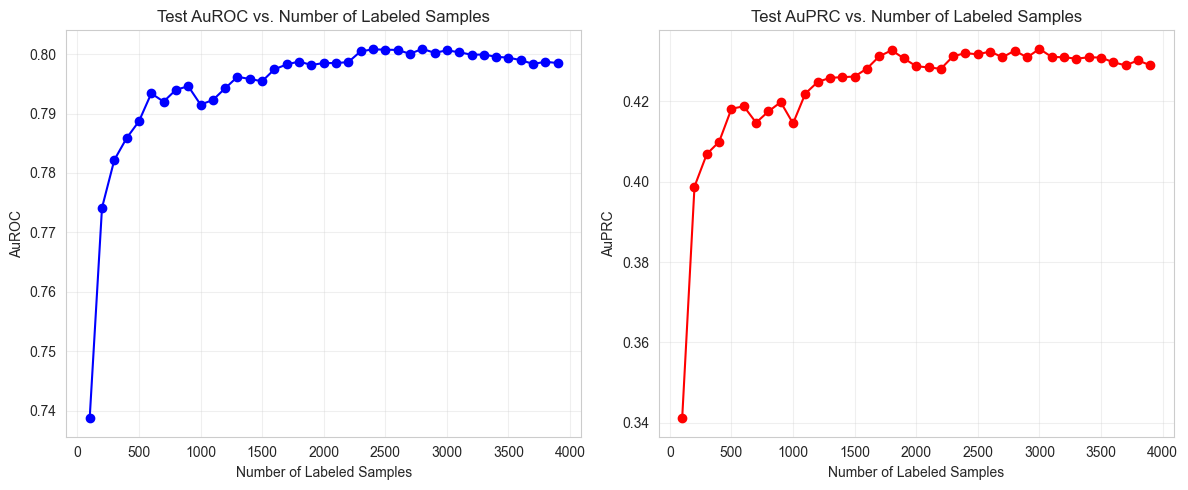

In [20]:
# Sample sizes to evaluate
sample_sizes = list(range(100, 4000, 100))
results = []

# Train and evaluate for each sample size
for n in sample_sizes:
    print(f"\nTraining with {n} labeled samples:")
    _, auc, auprc = train_linear_probe_sparse(X_train, y_train, X_test, y_test, n)
    
    print(f"Test AuROC: {auc:.4f}")
    print(f"Test AuPRC: {auprc:.4f}")
    
    results.append({
        'n_samples': n,
        'AuROC': auc,
        'AuPRC': auprc
    })
results_df = pd.DataFrame(results)
print("\nResults summary:")
print(results_df)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(results_df['n_samples'], results_df['AuROC'], 'o-', color='blue')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('AuROC')
plt.title('Test AuROC vs. Number of Labeled Samples')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(results_df['n_samples'], results_df['AuPRC'], 'o-', color='red')
plt.xlabel('Number of Labeled Samples')
plt.ylabel('AuPRC')
plt.title('Test AuPRC vs. Number of Labeled Samples')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('embedding_autoencoder_transformer/limited_labels_performance.png', dpi=300)
plt.show()

### Q3.3: Visualising Learned Representations (4 Pts)

We visualize the patient representations of the representation / latent space in two dimensions using t-SNE. 

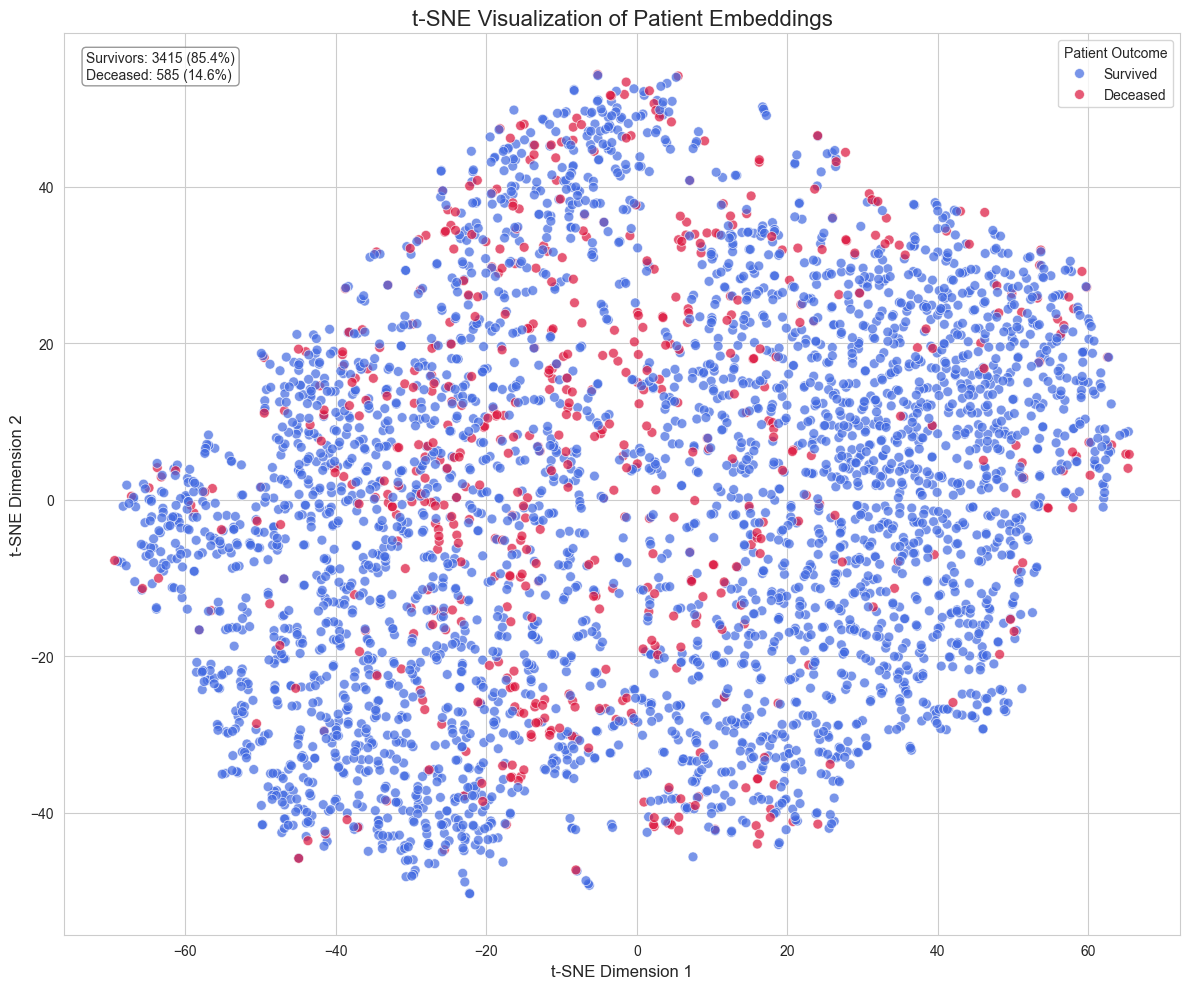

In [21]:
#Visualization of test set only
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)

# Convert PyTorch tensors to NumPy arrays
X_test_np = X_test.cpu().numpy()  # Move to CPU if on GPU and convert to NumPy
y_test_np = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test

# Fit t-SNE
X_tsne = tsne.fit_transform(X_test_np)

# Create DataFrame for visualization
tsne_df = pd.DataFrame({
    'x': X_tsne[:, 0],
    'y': X_tsne[:, 1],
    'label': y_test_np
})

tsne_df['label'] = tsne_df['label'].astype('category')

# Plot with different colors for labels 0 or 1
plt.figure(figsize=(12, 10))
scatter = sns.scatterplot(
    x='x', y='y',
    hue='label',
    palette={0: 'royalblue', 1: 'crimson'},
    data=tsne_df,
    alpha=0.7,
    s=50,
)

handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Survived', 'Deceased'], title='Patient Outcome')
plt.title('t-SNE Visualization of Patient Embeddings', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)

survivors = (y_test_np == 0).sum()
deceased = (y_test_np == 1).sum()
total = len(y_test_np)

plt.annotate(f'Survivors: {survivors} ({survivors/total:.1%})\nDeceased: {deceased} ({deceased/total:.1%})',
             xy=(0.02, 0.98), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
             ha='left', va='top', fontsize=10)

plt.tight_layout()
plt.savefig('embedding_autoencoder_transformer/tsne_visualization_test.png', dpi=300)
plt.show()

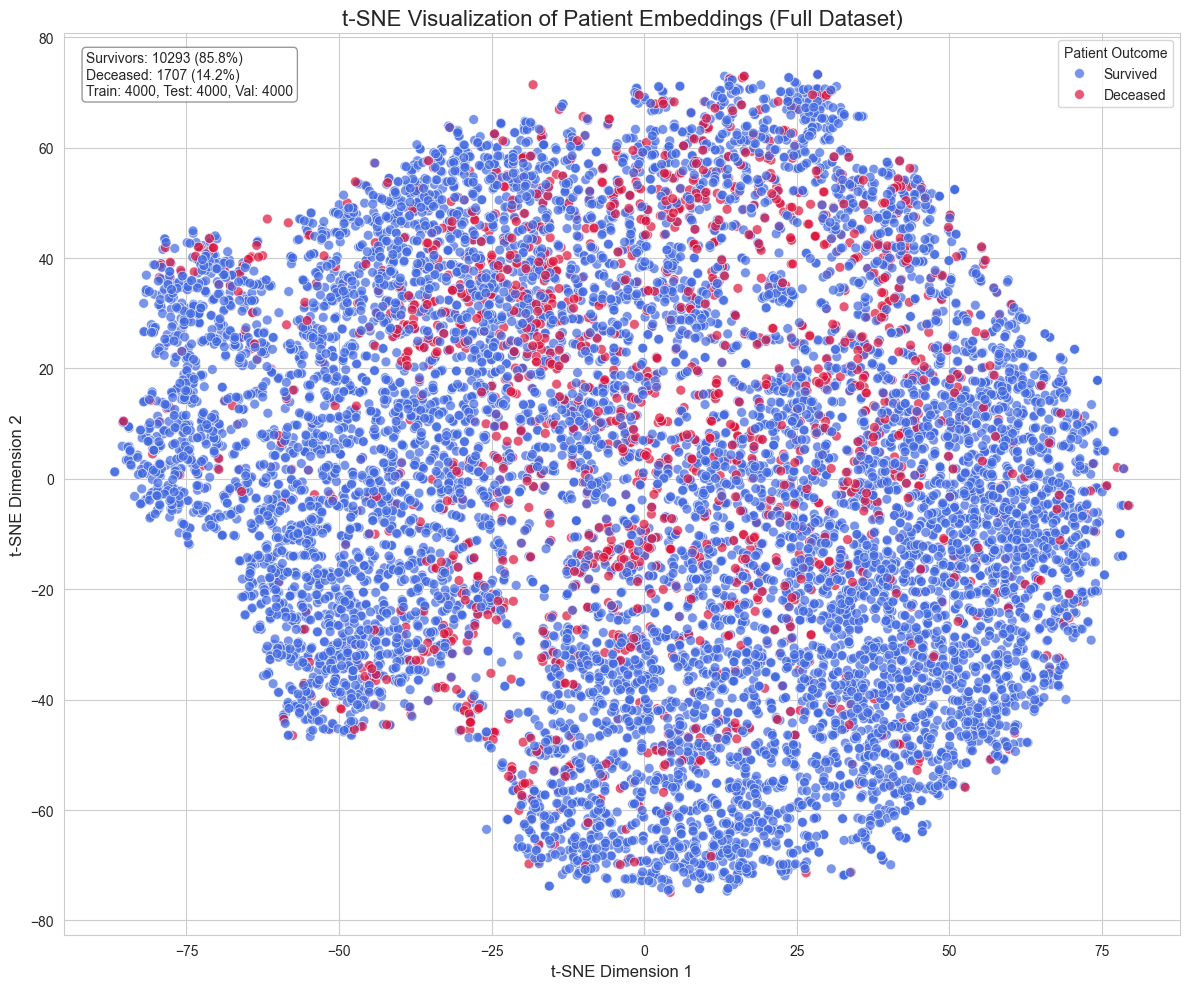

In [22]:
# Combine all sets
X_combined = torch.cat([X_train, X_test, X_val], dim=0)
if isinstance(y_train, torch.Tensor):
    y_combined = torch.cat([y_train, y_test, y_val], dim=0)
else:
    y_combined = np.concatenate([y_train, y_test, y_val])

# Create set labels to track which dataset each point came from
set_labels = np.array(['Train'] * len(X_train) + ['Test'] * len(X_test) + ['Validation'] * len(X_val))

# Convert to NumPy arrays for t-SNE
X_combined_np = X_combined.cpu().numpy()
y_combined_np = y_combined.cpu().numpy() if isinstance(y_combined, torch.Tensor) else y_combined

# Fit t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_combined_np)

# Create DataFrame for visualization
tsne_df = pd.DataFrame({
    'x': X_tsne[:, 0],
    'y': X_tsne[:, 1],
    'outcome': y_combined_np,
    'dataset': set_labels
})

# Convert to category
tsne_df['outcome'] = tsne_df['outcome'].astype('category')

# Create a single plot colored by outcome
plt.figure(figsize=(12, 10))
scatter = sns.scatterplot(
    x='x', y='y',
    hue='outcome',
    palette={0: 'royalblue', 1: 'crimson'},
    data=tsne_df,
    alpha=0.7,
    s=50,
)

handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Survived', 'Deceased'], title='Patient Outcome')
plt.title('t-SNE Visualization of Patient Embeddings (Full Dataset)', fontsize=16)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)

# Add statistics annotation
survivors = (y_combined_np == 0).sum()
deceased = (y_combined_np == 1).sum()
total = len(y_combined_np)

stats_text = (f'Survivors: {survivors} ({survivors/total:.1%})\n'
              f'Deceased: {deceased} ({deceased/total:.1%})\n'
              f'Train: {len(X_train)}, Test: {len(X_test)}, Val: {len(X_val)}')

plt.annotate(stats_text, xy=(0.02, 0.98), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
             ha='left', va='top', fontsize=10)

plt.tight_layout()
plt.savefig('embedding_autoencoder_transformer/combined_tsne_visualization.png', dpi=300)
plt.show()

Now, we answer the question whether data points are distributed differently for different labels.

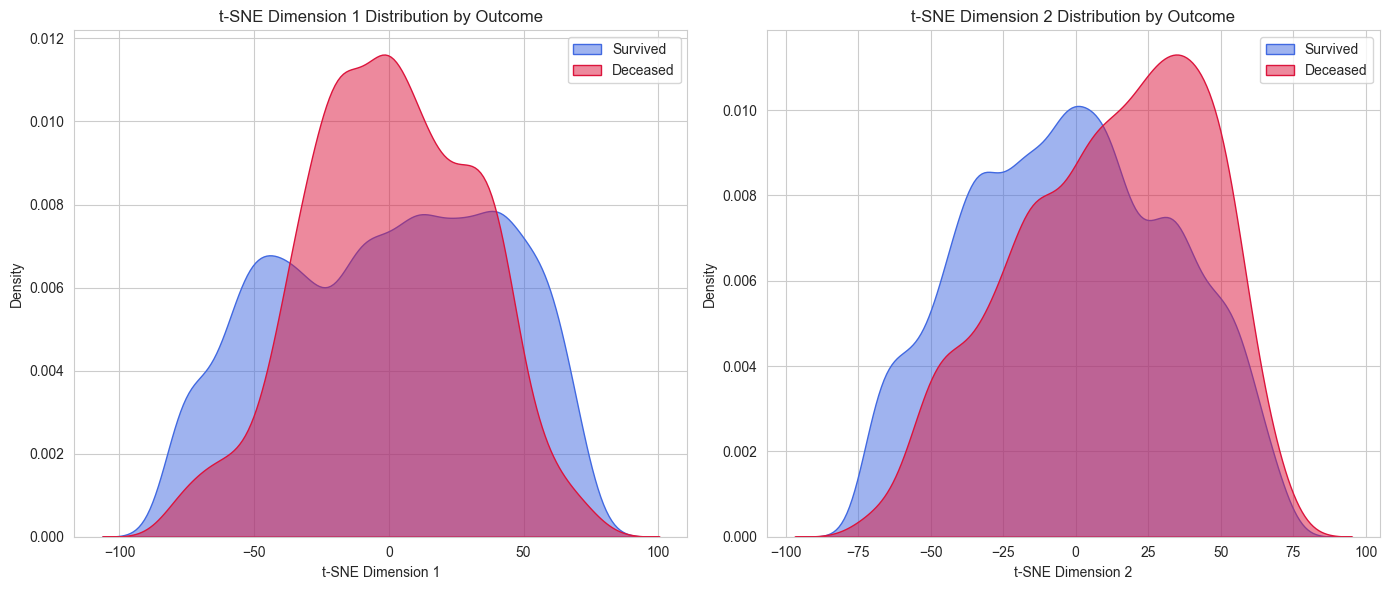

In [23]:
# Separate visualization with density plots for each class, two subplots for dimension 1 and 2
plt.figure(figsize=(14, 6))
for i, dim in enumerate(['x', 'y']):
    plt.subplot(1, 2, i+1)
    for label, color in zip([0, 1], ['royalblue', 'crimson']):
        subset = tsne_df[tsne_df['outcome'] == label]  # Changed 'label' to 'outcome'
        sns.kdeplot(subset[dim], fill=True, color=color, alpha=0.5, 
                   label='Survived' if label == 0 else 'Deceased')
    
    plt.title(f't-SNE Dimension {i+1} Distribution by Outcome')
    plt.xlabel(f't-SNE Dimension {i+1}')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.savefig('embedding_autoencoder_transformer/tsne_density_by_class.png', dpi=300)
plt.show()

Next, we compare different clustering algorithms to assess the quality of our dimensionality reduction w.r.t. target class labels.

/Users/melanierieff/PycharmProjects/ML4H_project1/.venv/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Clustering Algorithm Comparison:
algorithm      ari      nmi  silhouette  num_clusters
   KMeans 0.002000 0.001590    0.408231             2
 Spectral 0.001667 0.000146    0.091610             2
   DBSCAN 0.003499 0.019578    0.232208            17


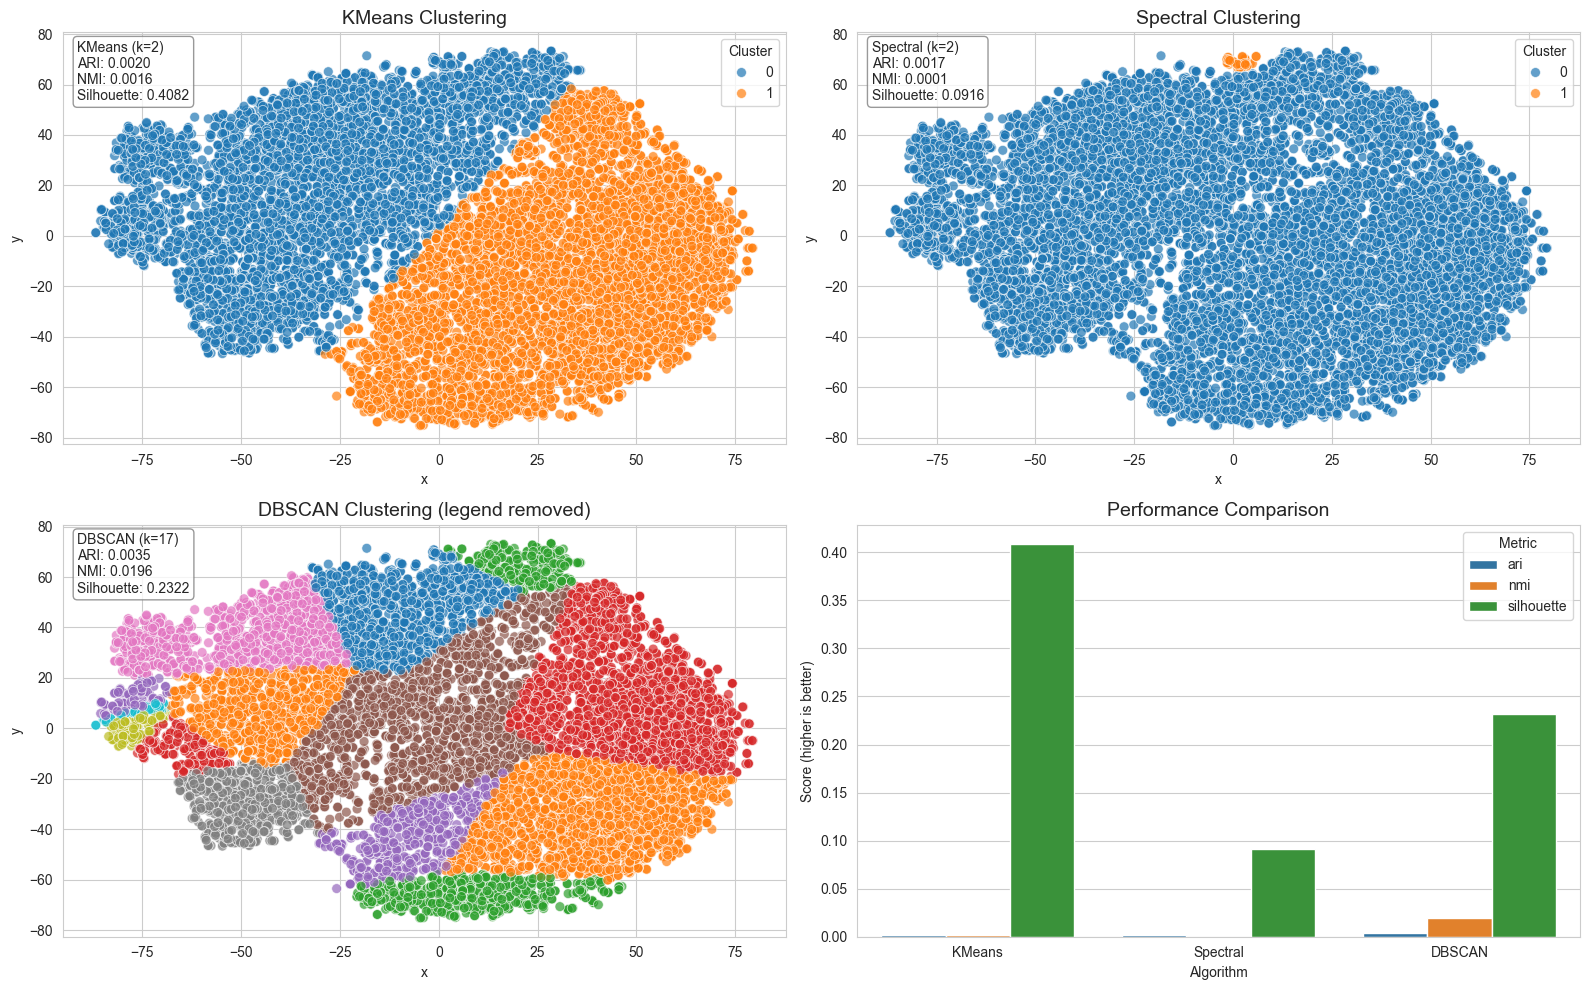

In [24]:
true_labels = tsne_df['outcome'].values

def evaluate_clustering(X, labels, true_labels, algorithm_name):
    # Check if we have at least 2 clusters
    unique_clusters = np.unique(labels)
    if len(unique_clusters) < 2:
        print(f"Warning: {algorithm_name} produced only {len(unique_clusters)} cluster(s)!")
        return {
            'algorithm': algorithm_name,
            'ari': 0,
            'nmi': 0,
            'silhouette': 0,
            'num_clusters': len(unique_clusters)
        }
    
    ari = adjusted_rand_score(true_labels, labels)
    nmi = normalized_mutual_info_score(true_labels, labels)
    silhouette = silhouette_score(X, labels)
    
    return {
        'algorithm': algorithm_name,
        'ari': ari,
        'nmi': nmi,
        'silhouette': silhouette,
        'num_clusters': len(unique_clusters)
    }

def compare_clustering_algorithms(X, true_labels):
    results = []
    cluster_labels = {}
    
    # 1. K-Means Clustering
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X)
    cluster_labels['KMeans'] = kmeans_labels
    results.append(evaluate_clustering(X, kmeans_labels, true_labels, 'KMeans'))
    
    # 2. Spectral Clustering
    spectral = SpectralClustering(n_clusters=2, random_state=42, affinity='nearest_neighbors')
    spectral_labels = spectral.fit_predict(X)
    cluster_labels['Spectral'] = spectral_labels
    results.append(evaluate_clustering(X, spectral_labels, true_labels, 'Spectral'))
    
    # 3. DBSCAN - requires tuning for eps
    # Estimate epsilon using nearest neighbors
    nn = NearestNeighbors(n_neighbors=2)
    nn.fit(X)
    distances, indices = nn.kneighbors(X)
    distances = np.sort(distances[:, 1])
    
    eps_candidate = np.mean(distances)

    dbscan = DBSCAN(eps=eps_candidate, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X)

    if len(np.unique(dbscan_labels)) == 1 and -1 in dbscan_labels:
        eps_candidate = np.percentile(distances, 90)
        dbscan = DBSCAN(eps=eps_candidate, min_samples=5)
        dbscan_labels = dbscan.fit_predict(X)
    
    if -1 in dbscan_labels:
        working_labels = dbscan_labels.copy()
        
        # For each noise point, assign to nearest non-noise cluster
        noise_indices = np.where(working_labels == -1)[0]
        non_noise_indices = np.where(working_labels != -1)[0]
        
        if len(non_noise_indices) > 0 and len(noise_indices) > 0:
            non_noise_samples = X[non_noise_indices]
            non_noise_labels = working_labels[non_noise_indices]

            nn_non_noise = NearestNeighbors(n_neighbors=1)
            nn_non_noise.fit(non_noise_samples)
            
            for idx in noise_indices:
                distances, indices = nn_non_noise.kneighbors([X[idx]])
                closest_non_noise_idx = non_noise_indices[indices[0][0]]
                working_labels[idx] = working_labels[closest_non_noise_idx]
            
            dbscan_labels = working_labels
    
    cluster_labels['DBSCAN'] = dbscan_labels
    results.append(evaluate_clustering(X, dbscan_labels, true_labels, 'DBSCAN'))
    
    return pd.DataFrame(results), cluster_labels

results_df, all_labels = compare_clustering_algorithms(X_tsne, true_labels)

print("Clustering Algorithm Comparison:")
print(results_df.to_string(index=False))

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# Plot each clustering result
axes = [ax1, ax2, ax3]
algorithms = ['KMeans', 'Spectral', 'DBSCAN']

for i, algorithm in enumerate(algorithms):
    plot_df = tsne_df.copy()
    plot_df['cluster'] = all_labels[algorithm]
    
    unique_clusters = np.unique(all_labels[algorithm])
    palette = sns.color_palette("tab10", len(unique_clusters))
    color_dict = {cluster: palette[i] for i, cluster in enumerate(unique_clusters)}
    
    sns.scatterplot(
        x='x', y='y',
        hue='cluster',
        palette=color_dict,
        data=plot_df,
        alpha=0.7,
        s=50,
        ax=axes[i]
    )
    
    algorithm_results = results_df[results_df['algorithm'] == algorithm].iloc[0]
    metrics_text = (
        f"{algorithm} (k={algorithm_results['num_clusters']})\n"
        f"ARI: {algorithm_results['ari']:.4f}\n"
        f"NMI: {algorithm_results['nmi']:.4f}\n"
        f"Silhouette: {algorithm_results['silhouette']:.4f}"
    )
    axes[i].text(0.02, 0.98, metrics_text, transform=axes[i].transAxes,
                 verticalalignment='top', horizontalalignment='left',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
    
    axes[i].set_title(f'{algorithm} Clustering', fontsize=14)
    if algorithm == 'DBSCAN':
        axes[i].get_legend().remove()
        axes[i].set_title(f'{algorithm} Clustering (legend removed)', fontsize=14)
    else:
        axes[i].legend(title='Cluster')

metrics = ['ari', 'nmi', 'silhouette']
metrics_data = results_df[['algorithm'] + metrics].melt(id_vars=['algorithm'], value_vars=metrics)

sns.barplot(x='algorithm', y='value', hue='variable', data=metrics_data, ax=ax4)
ax4.set_title('Performance Comparison', fontsize=14)
ax4.set_ylabel('Score (higher is better)')
ax4.set_xlabel('Algorithm')
ax4.legend(title='Metric')

#plt.suptitle('Comparison of Clustering Algorithms on t-SNE Data', fontsize=18, y=0.98)

plt.tight_layout()
plt.savefig('embedding_autoencoder_transformer/clustering_complete_comparison.png', dpi=300)
plt.show()

K-means Clustering Accuracy: 0.8578


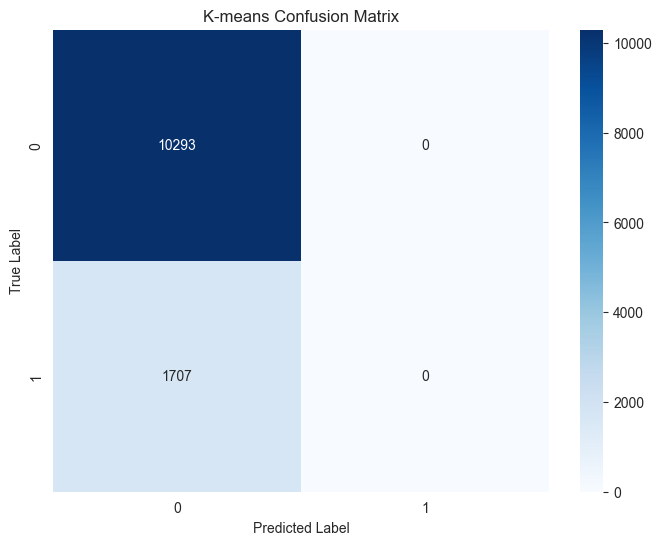

In [25]:
kmeans_labels = all_labels['KMeans']
# Create a mapping from each cluster to the most common true label in that cluster
cluster_to_label = {}
for cluster_id in np.unique(kmeans_labels):
    cluster_indices = np.where(kmeans_labels == cluster_id)[0]
    cluster_true_labels = true_labels[cluster_indices]
    most_common_label = np.bincount(cluster_true_labels.astype(int)).argmax()
    cluster_to_label[cluster_id] = most_common_label

predicted_labels = np.array([cluster_to_label[label] for label in kmeans_labels])
kmeans_accuracy = accuracy_score(true_labels, predicted_labels)
print(f"K-means Clustering Accuracy: {kmeans_accuracy:.4f}")

cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('K-means Confusion Matrix')
plt.show()